<a href="https://colab.research.google.com/github/fintech-projects/google-colab/blob/main/Finger_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the key libraries

In [ ]:
import numpy as np
import os 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
import io

print (tf.__version__)

2.6.0


# Importing the data

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json 
!kaggle datasets download -d koryakinp/fingers
from zipfile import ZipFile
file_name = "fingers.zip"

Saving kaggle.json to kaggle (1).json
fingers.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


# Organizing the data into folders

In [ ]:
import glob

Pngfiles_Train = []
Pngfiles_Test = []

os.chdir('/content/train')

for files in glob.glob("*.png"):
  Pngfiles_Train.append(files)

os.chdir('/content/test')

for files in glob.glob("*.png"):
  Pngfiles_Test.append(files)

In [ ]:
Classes = ['0L', '1L', '2L', '3L', '4L', '5L', '0R', '1R', '2R', '3R', '4R', '5R']

if not os.path.exists('/content/Train'):
  os.mkdir('/content/Train')

if not os.path.exists('/content/Test'):
  os.mkdir('/content/Test')

In [ ]:
for i in Classes:
  if not os.path.exists('/content/Train/'+i):
    os.mkdir('/content/Train/'+i)

for i in Classes:
  if not os.path.exists('/content/Test/'+i):
    os.mkdir('/content/Test/'+i)

In [ ]:
# Training set

import shutil

os.chdir('/content/train')

for i in Pngfiles_Train:
  last_two = i[-6:-4]
  shutil.copy(i, '/content/Train/{}'.format(last_two))

os.chdir('/content/test')
for i in Pngfiles_Test:
  last_two = i[-6:-4]
  shutil.copy(i, '/content/Test/{}'.format(last_two))

# Importing the Training dataset

In [ ]:
Batch_size = 32
Image_size = (128,128)

training_set = tf.keras.preprocessing.image_dataset_from_directory(directory = '/content/Train',
                                                                   batch_size = Batch_size,
                                                                   image_size = Image_size,
                                                                   label_mode = 'categorical')

Found 18000 files belonging to 12 classes.


### Visualizing the imported results

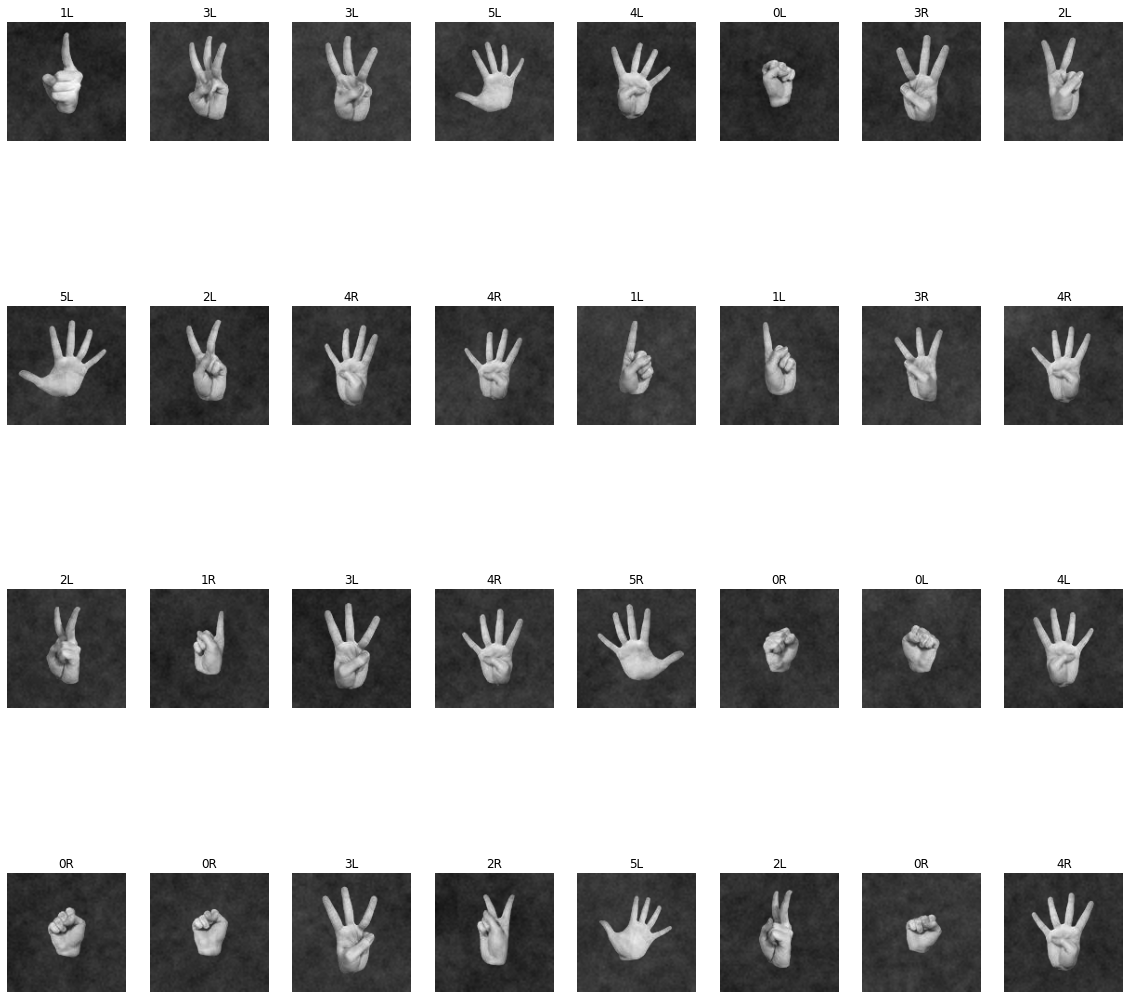

In [ ]:
class_names = training_set.class_names

plt.figure(figsize = (20,20))

for image, label in training_set.take(1):
  for i in range(0,32):
    plt.subplot(4,8,i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(class_names[np.where(label[i].numpy() == 1)[0][0]])
    plt.axis('off')

plt.show()

# Importing the Test dataset

In [ ]:
Batch_size = 32
Image_size = (128,128)

test_set = tf.keras.preprocessing.image_dataset_from_directory(directory = '/content/Test',
                                                                   batch_size = Batch_size,
                                                                   image_size = Image_size,
                                                                   label_mode = 'categorical')

Found 3600 files belonging to 12 classes.


### Splitting the Test Set into the Validation set and Test set

In [ ]:
val_batches = test_set.cardinality()

validation_set = test_set.take(val_batches//5)

test_set = test_set.skip(val_batches//5)

print ('Number of batches in the Test set: {}'.format(test_set.cardinality().numpy()))
print ('')
print ('Number of batches in the Validation set: {}'.format(validation_set.cardinality().numpy()))

Number of batches in the Test set: 91

Number of batches in the Validation set: 22


### Configure the data to improve performance

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

training_set = training_set.prefetch(buffer_size = AUTOTUNE)
test_set = test_set.prefetch(buffer_size = AUTOTUNE)
validation_set = validation_set.prefetch(buffer_size = AUTOTUNE)

# Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(-0.3),
                                         tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1,0.1)])

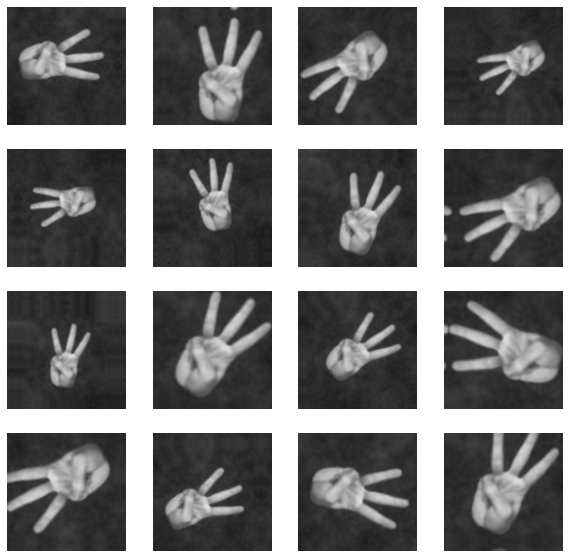

In [ ]:
plt.figure(figsize = (10,10))

for image, label in training_set.take(1):
  im = image[1]
  for i in range(0,16):
    plt.subplot(4,4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(im,0))
    plt.imshow(augmented_image[0]/255)
    plt.axis('off')

plt.show()

In [ ]:
data_augmentation.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale = 1./127.5, offset = -1))

# Build the CNN

### Building the custom model

In [ ]:
Input_shape_n = Image_size + (3,)

In [ ]:
Model = tf.keras.Sequential()
Model.add(data_augmentation)
Model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size= 3, padding='same', activation= 'relu', input_shape = Input_shape_n))
Model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size= 3, padding='same', activation= 'relu'))
Model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, padding = 'valid'))
Model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size= 3, padding='same', activation= 'relu'))
Model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, padding = 'valid'))
Model.add(tf.keras.layers.Flatten())
Model.add(tf.keras.layers.Dropout(0.3))
Model.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
Model.add(tf.keras.layers.Dense(units = 12, activation = 'softmax'))

In [ ]:
Model.compile(optimizer= 'Adam', 
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

In [ ]:
loss0, accuracy0 = Model.evaluate(validation_set)

22/22 [==============================] - 6s 28ms/step - loss: 2.4915 - accuracy: 0.0795


In [ ]:
Model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)            

In [ ]:
checkpoint_dir = '/content/checkpoints/cpkt_{epoch}'

cp_callback = tf.keras.callbacks.ModelCheckpoint( filepath = checkpoint_dir, save_weights_only= True )

In [ ]:
History = Model.fit(training_set, validation_data = validation_set, epochs = 10, callbacks = [cp_callback])

Epoch 1/10
563/563 [==============================] - 47s 80ms/step - loss: 1.4163 - accuracy: 0.4612 - val_loss: 0.4594 - val_accuracy: 0.8168
Epoch 2/10
563/563 [==============================] - 45s 79ms/step - loss: 0.4962 - accuracy: 0.8041 - val_loss: 0.6210 - val_accuracy: 0.7884
Epoch 3/10
563/563 [==============================] - 44s 79ms/step - loss: 0.3192 - accuracy: 0.8729 - val_loss: 0.3766 - val_accuracy: 0.8750
Epoch 4/10
563/563 [==============================] - 44s 78ms/step - loss: 0.2472 - accuracy: 0.9059 - val_loss: 0.1620 - val_accuracy: 0.9446
Epoch 5/10
563/563 [==============================] - 45s 79ms/step - loss: 0.2118 - accuracy: 0.9229 - val_loss: 0.1735 - val_accuracy: 0.9474
Epoch 6/10
563/563 [==============================] - 44s 78ms/step - loss: 0.1867 - accuracy: 0.9297 - val_loss: 0.1464 - val_accuracy: 0.9517
Epoch 7/10
563/563 [==============================] - 45s 79ms/step - loss: 0.1681 - accuracy: 0.9354 - val_loss: 0.1840 - val_accuracy:

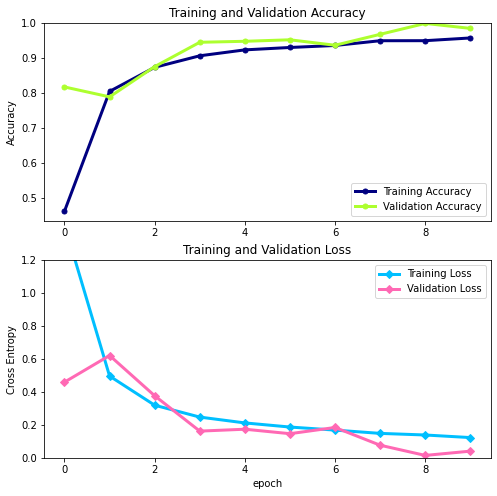

In [ ]:
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']

loss = History.history['loss']
val_loss = History.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', linewidth = 3, marker = 'o', ms = 5, color = 'navy')
plt.plot(val_acc, label='Validation Accuracy',linewidth = 3, marker = 'o', ms = 5, color = 'greenyellow')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss',linewidth = 3, marker = 'D', ms = 5, color = 'deepskyblue')
plt.plot(val_loss, label='Validation Loss',linewidth = 3, marker = 'D', ms = 5, color = 'hotpink')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
Model.evaluate(test_set)

91/91 [==============================] - 4s 40ms/step - loss: 0.0471 - accuracy: 0.9827


[0.04709100350737572, 0.9827347993850708]

# Saving the model

In [ ]:
if not os.path.exists('/content/'):
  os.mkdir('/content/')

In [ ]:
Model.save('/content/Fingers.h5')